In [1]:
import matplotlib.pyplot as plt
import scipy

In [26]:
# 파일 불러오기
# data = mat73.loadmat("Rutledge_GBE_risk_data_TOD.mat")
data = scipy.io.loadmat("Rutledge_GBE_risk_data_TOD.mat")

# 주요 구조 확인
print(data.keys())


dict_keys(['__header__', '__version__', '__globals__', 'depData', 'subjData'])


# Rutledge(2014)

## Depression Preprocessing
DepData = subjData + dep 정보만 추출(not trial)

In [47]:
depData = data['depData']

# 1차원으로 펴기
depData = depData[0]

# 참가자 수 확인
print("총 참가자 수:", len(depData))  # 47067
print("첫 번째 참가자의 필드 목록:", depData[0].dtype.names)

총 참가자 수: 1858
첫 번째 참가자의 필드 목록: ('id', 'age', 'isFemale', 'location', 'lifeSatisfaction', 'education', 'nativeLanguage', 'deviceType', 'nPlays', 'timesPlayed', 'dayNumber', 'timeOfDay', 'designVersion', 'dataHdr', 'data', 'depStatus', 'depEpisodes', 'depYears', 'depMeds', 'depFamily', 'bdiDayNumber', 'bdiRaw', 'bdiTotal')


In [48]:
subject = depData[0]  # 첫 참가자 구조체

print("id:", subject['id'][0][0])
print("age group:", subject['age'][0][0])
print("trial matrix shape:", subject['data'][0][0].shape)  # (30, 15)

id: 89
age group: 5
trial matrix shape: (30, 15)


In [49]:
import pandas as pd
import numpy as np

# depData 변환
dep_rows = []
dep_rows.append(depData[0].dtype.names)

for dep in depData:
    temp_list = []
    for idx in range(len(depData[0].dtype.names)):
        temp_list.append(dep[idx][0][0])      
    dep_rows.append(temp_list)

In [50]:
# 첫 번째 항목을 헤더로 지정하고 나머지를 데이터로
header = dep_rows[0]
rows = dep_rows[1:]

# DataFrame 생성
df = pd.DataFrame(rows, columns=header)
df = df.drop(columns=['data', 'dataHdr'], errors='ignore')

# 결과 확인
df.to_csv("participant_info.csv", index=False)

In [51]:
df

,id,age,isFemale,location,lifeSatisfaction,education,nativeLanguage,deviceType,nPlays,timesPlayed,...,timeOfDay,designVersion,depStatus,depEpisodes,depYears,depMeds,depFamily,bdiDayNumber,bdiRaw,bdiTotal
0,89,5,1,400,7,1,1.0,i,2,1,...,0.991713,1,2,5,5,4,1,242,0,6
1,92,3,0,3,6,3,1.0,i,4,2,...,0.898831,1,2,5,5,4,2,229,0,6
2,106,4,1,3,7,3,1.0,i,7,1,...,0.039907,1,2,1,5,4,3,335,0,1
3,113,4,1,400,7,3,1.0,i,2,1,...,0.079664,1,3,5,5,3,2,268,0,2
4,194,6,0,900,6,3,1.0,i,2,1,...,0.324479,1,3,5,5,4,3,332,0,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1853,44342,2,0,207,2,3,8.0,a,5,1,...,0.144606,5,3,5,5,4,3,74,1,13
1854,44364,2,0,107,7,1,9.0,a,1,2,...,0.947153,5,3,5,5,4,3,73,0,3
1855,44368,4,1,205,5,2,3.0,a,1,1,...,0.435417,5,3,5,5,4,3,72,0,14
1856,44375,5,1,3,8,3,1.0,a,1,1,...,0.846238,5,3,5,5,4,3,72,0,3


### Data features
Especially depression

In [52]:
# depStatus Have you ever been diagnosed with depression?
# 1 Yes, by a psychiatrist
# 2 Yes, by a family doctor or another doctor but not a psychiatrist
# 3 No, I have never been diagnosed with depression
# 4 I’d rather not say

df['depStatus'].value_counts()

depStatus
3    1287
2     316
1     224
4      31
Name: count, dtype: int64

In [53]:
bins = [0, 13, 19, 28, 63]  # 직접 지정한 구간
labels = ["Minimal", "Mild", "High", "Severe"]

df['BDI_bin'] = pd.cut(df['bdiTotal'], bins=bins, labels=labels, right=True)

# 구간별 개수 출력
bin_counts = df['BDI_bin'].value_counts().sort_index()
print(bin_counts)

BDI_bin
Minimal    1105
Mild        230
High        228
Severe      176
Name: count, dtype: int64


## Trials

In [54]:
id_row = df['id']
id_row

0          89
1          92
2         106
3         113
4         194
        ...  
1853    44342
1854    44364
1855    44368
1856    44375
1857    44455
Name: id, Length: 1858, dtype: uint16

In [55]:
parData_row = []

for idx in range(0,len(id_row)): 
    par_id = depData[idx]['id'][0][0]
    trial_matrix = depData[idx]['data'][0][0]  # (30, 15) 행렬이 여기에 있음

    for i in range(0, len(trial_matrix)):
        temp = [int(par_id)]
        mat = trial_matrix[i]
        
        for n in range(len(trial_matrix[i])):
            temp.append(float(mat[n]))
        parData_row.append(temp)

print(parData_row[0])
print(len(parData_row[0]))
print(len(parData_row))

[89, 1.0, 1.0, 0.0, 40.0, -14.0, nan, 1.0, 40.0, 9.784, 70.0, 50.0, 7.467, nan, 4.382, 6.239]
16
55740


In [56]:
subjData = data['subjData']

# 1차원으로 펴기
subjData = subjData[0]

headers = subjData[0]['dataHdr'][0]
header_row = ['id']
for elm in headers:
    header_row.append(str(elm[0]))
header_row

['id',
 'nTrial',
 'riskySide',
 'certainValue',
 'winValue',
 'loseValue',
 'empty',
 'choseRisky',
 'outcome',
 'choiceRT',
 'happiness',
 'startValue',
 'happinessRT',
 'empty',
 'spinDuration',
 'spinAngle']

In [57]:
df = pd.DataFrame(parData_row, columns=header_row)
df = df.drop(columns=['empty', 'empty'], errors='ignore')

# 결과 확인
df.to_csv("participant_trials.csv", index=False)

## SubjData

In [58]:
subjData = data['subjData']

# 1차원으로 펴기
subjData = subjData[0]

# 참가자 수 확인
print("총 참가자 수:", len(subjData))  # 47067
print("첫 번째 참가자의 필드 목록:", subjData[0].dtype.names)

총 참가자 수: 47067
첫 번째 참가자의 필드 목록: ('id', 'age', 'isFemale', 'location', 'lifeSatisfaction', 'education', 'nativeLanguage', 'deviceType', 'nPlays', 'timesPlayed', 'dayNumber', 'timeOfDay', 'designVersion', 'dataHdr', 'data')


In [59]:
subject = subjData[0]  # 첫 참가자 구조체

print("id:", subject['id'][0][0])
print("age group:", subject['age'][0][0])
print("trial matrix shape:", subject['data'][0][0].shape)  # (30, 15)

id: 1
age group: 3
trial matrix shape: (30, 15)


In [60]:
headers = subjData[0]['dataHdr'][0]
print("열 이름 목록:")
for idx, h in enumerate(headers):
    print(f"{idx+1:2d}: {h}")

열 이름 목록:
 1: ['nTrial']
 2: ['riskySide']
 3: ['certainValue']
 4: ['winValue']
 5: ['loseValue']
 6: ['empty']
 7: ['choseRisky']
 8: ['outcome']
 9: ['choiceRT']
10: ['happiness']
11: ['startValue']
12: ['happinessRT']
13: ['empty']
14: ['spinDuration']
15: ['spinAngle']


In [61]:
trial_matrix = subjData[0]['data'][0][0]  # (30, 15) 행렬이 여기에 있음
print(trial_matrix.shape)
print(trial_matrix[:5])  # 상위 5개 trial 확인

(30, 15)
[[ 1.0000e+00  1.0000e+00 -5.5000e+01  0.0000e+00 -2.2000e+02         nan
   1.0000e+00 -2.2000e+02  1.8239e+01  7.0000e+01  5.0000e+01  6.9570e+00
          nan  9.3050e+00  4.4000e-02]
 [ 2.0000e+00  1.0000e+00  4.5000e+01  1.2200e+02  0.0000e+00         nan
   0.0000e+00  4.5000e+01  5.0230e+00         nan         nan         nan
          nan         nan         nan]
 [ 3.0000e+00  1.0000e+00  5.5000e+01  1.3200e+02  0.0000e+00         nan
   1.0000e+00  1.3200e+02  4.3170e+00  8.2000e+01  5.0000e+01  4.6460e+00
          nan  9.6750e+00  3.9770e+00]
 [ 4.0000e+00  1.0000e+00 -3.5000e+01  0.0000e+00 -7.0000e+01         nan
   0.0000e+00 -3.5000e+01  6.3570e+00         nan         nan         nan
          nan         nan         nan]
 [ 5.0000e+00  1.0000e+00 -5.5000e+01  0.0000e+00 -1.2000e+02         nan
   0.0000e+00 -5.5000e+01  9.3970e+00         nan         nan         nan
          nan         nan         nan]]


In [62]:
trial_matrix = subjData[0]['data'][0][0]  # shape (30, 15)

# 예: 3번째 열 (safeValue)만 보기
safe_vals = trial_matrix[:, 2]  # column index는 0부터 시작
print(safe_vals)

# 예: gamble 여부 (col 7), happiness (col 10)
choices = trial_matrix[:, 6]
happiness = trial_matrix[:, 9]
print(choices)
print(happiness)

[-55.  45.  55. -35. -55.   0.  35. -55.  55.  45. -55.  55.  45. -30.
   0. -55. -45.  30.   0.   0.   0.  35.   0.  30.  35.   0. -45.   0.
 -45. -35.]
[1. 0. 1. 0. 0. 1. 1. 1. 0. 0. 0. 1. 0. 1. 0. 0. 1. 0. 0. 0. 1. 1. 0. 0.
 1. 1. 0. 1. 1. 1.]
[ 70.  nan  82.  nan  nan  78.  nan  nan  71.  nan  50.  nan  nan  23.
  nan  nan  50.  nan  nan  50.  nan  27.  nan  nan  50.  nan  nan 100.
  nan 100.]


# Blain(2020)

## CSV 만들기

In [2]:
# 파일 불러오기
# data = mat73.loadmat("Rutledge_GBE_risk_data_TOD.mat")
dataBl = scipy.io.loadmat("Blain_MoodTracksLearning_data.mat")

# 주요 구조 확인
print(dataBl.keys())

dict_keys(['__header__', '__version__', '__globals__', 'stable2volatile_data', 'volatile2stable_data'])


In [3]:
# helper: mat_struct -> dict
def mat_struct_to_dict(mat_struct):
    result = {}
    for field in mat_struct._fieldnames:
        val = getattr(mat_struct, field)
        if isinstance(val, np.ndarray) and val.size == 1:
            val = val.item()
        result[field] = val
    return result

In [4]:
# 데이터 불러오기
dataBl = scipy.io.loadmat("Blain_MoodTracksLearning_data.mat", 
                          struct_as_record=False, squeeze_me=True)
v2s_data = dataBl["volatile2stable_data"]
s2v_data = dataBl["stable2volatile_data"]
print(v2s_data[0]._fieldnames)
print(v2s_data[0].main._fieldnames)

['id', 'date', 'age', 'gender', 'BDI', 'PHQ', 'STAI', 'HPS', 'main']
['id', 'gender', 'age', 'starttimenum', 'starttime', 'date', 'dir', 'filename', 'netdir', 'background', 'sidelocation', 'sidelocation_outcome', 'FontSizeText', 'FontSizeTask', 'iti', 'iti_std', 'iti_instruction', 'time', 'timeout', 'timeout_instruction', 'optiontime', 'outcometime', 'choiceoffset', 'choiceconfirmationtime', 'outcometime_sign', 'outcometime_magnitude', 'leftrep', 'rightrep', 'ntrials', 'ntrials_context', 'nslots', 'order_tmp', 'order', 'env_cues', 'colors', 'index_color', 'colorleft', 'colorright', 'happytrials_task', 'blockside', 'list_pair', 'newcontext', 'upperbound', 'lowerbound', 'slot_sigmad', 'lambda', 'init', 'index_reversals', 'task_mu_tmp', 'task_mu', 'mat_mag', 'index_mag', 'outcomes', 'picture_background', 'maintask']


### 참가자

In [31]:
# 결과 저장
import numpy as np
import pandas as pd

participant_rows = []
num = 0

# 참가자 별 정보 저장
for p in v2s_data:
    pid = getattr(p, "id", np.nan)
    base_info = {
        'id': pid + "v2s" + str(num),
        'age': getattr(p, "age", np.nan),
        'gender': getattr(p, "gender", np.nan),
    } 
    num += 1
    
    # 심리검사들 펼치기
    for field in ['BDI', 'PHQ', 'STAI', 'HPS']:
        substruct = getattr(p, field, None)
        if substruct is not None:
            flat = mat_struct_to_dict(substruct)
            for k, v in flat.items():
                base_info[f"{field}_{k}"] = v

    participant_rows.append(base_info)

# 데이터프레임 생성
participant_df = pd.DataFrame(participant_rows)

# 저장
participant_df.to_csv("volatile2stable_participant_info.csv", index=False)

In [32]:
print(participant_df.shape)
print(participant_df["id"].unique)

(38, 16)
<bound method Series.unique of 0      P_MoodFlexi_01_Behavior11_01v2s0
1      P_MoodFlexi_01_Behavior12_01v2s1
2      P_MoodFlexi_01_Behavior13_01v2s2
3      P_MoodFlexi_01_Behavior14_01v2s3
4      P_MoodFlexi_01_Behavior15_01v2s4
5       P_MoodFlexi_01_Behavior1_01v2s5
6      P_MoodFlexi_01_Behavior21_01v2s6
7      P_MoodFlexi_01_Behavior23_01v2s7
8      P_MoodFlexi_01_Behavior24_01v2s8
9      P_MoodFlexi_01_Behavior25_01v2s9
10    P_MoodFlexi_01_Behavior26_01v2s10
11    P_MoodFlexi_01_Behavior27_01v2s11
12    P_MoodFlexi_01_Behavior28_01v2s12
13    P_MoodFlexi_01_Behavior29_01v2s13
14     P_MoodFlexi_01_Behavior2_01v2s14
15    P_MoodFlexi_01_Behavior31_01v2s15
16    P_MoodFlexi_01_Behavior32_01v2s16
17    P_MoodFlexi_01_Behavior33_01v2s17
18    P_MoodFlexi_01_Behavior34_01v2s18
19    P_MoodFlexi_01_Behavior41_01v2s19
20    P_MoodFlexi_01_Behavior41_01v2s20
21    P_MoodFlexi_01_Behavior42_01v2s21
22    P_MoodFlexi_01_Behavior42_01v2s22
23    P_MoodFlexi_01_Behavior43_01v2s23


In [33]:
# 결과 저장
participant_rows = []
num = 0

# 참가자 별 정보 저장
for p in s2v_data:
    pid = getattr(p, "id", np.nan)
    base_info = {
        'id': pid + "s2v" + str(num),
        'age': getattr(p, "age", np.nan),
        'gender': getattr(p, "gender", np.nan),
    } 
    num += 1

    # 심리검사들 펼치기
    for field in ['BDI', 'PHQ', 'STAI', 'HPS']:
        substruct = getattr(p, field, None)
        if substruct is not None:
            flat = mat_struct_to_dict(substruct)
            for k, v in flat.items():
                base_info[f"{field}_{k}"] = v

    participant_rows.append(base_info)

# 데이터프레임 생성
participant_df = pd.DataFrame(participant_rows)

# 저장
participant_df.to_csv("stable2volatile_participant_info.csv", index=False)

In [34]:
print(participant_df.shape)
print(participant_df["id"].unique)

(37, 13)
<bound method Series.unique of 0      P_MoodFlexi_01_Behavior10_01s2v0
1      P_MoodFlexi_01_Behavior11_01s2v1
2      P_MoodFlexi_01_Behavior12_01s2v2
3      P_MoodFlexi_01_Behavior13_01s2v3
4      P_MoodFlexi_01_Behavior14_01s2v4
5      P_MoodFlexi_01_Behavior15_01s2v5
6      P_MoodFlexi_01_Behavior16_01s2v6
7      P_MoodFlexi_01_Behavior17_01s2v7
8      P_MoodFlexi_01_Behavior19_01s2v8
9       P_MoodFlexi_01_Behavior1_01s2v9
10    P_MoodFlexi_01_Behavior20_01s2v10
11    P_MoodFlexi_01_Behavior21_01s2v11
12    P_MoodFlexi_01_Behavior22_01s2v12
13    P_MoodFlexi_01_Behavior23_01s2v13
14    P_MoodFlexi_01_Behavior24_01s2v14
15     P_MoodFlexi_01_Behavior2_01s2v15
16    P_MoodFlexi_01_Behavior31_01s2v16
17    P_MoodFlexi_01_Behavior33_01s2v17
18    P_MoodFlexi_01_Behavior34_01s2v18
19    P_MoodFlexi_01_Behavior35_01s2v19
20     P_MoodFlexi_01_Behavior3_01s2v20
21     P_MoodFlexi_01_Behavior4_01s2v21
22     P_MoodFlexi_01_Behavior5_01s2v22
23     P_MoodFlexi_01_Behavior6_01s2v23


### 시행

### v2s

In [62]:
#v2s_data[0].main._fieldnames

In [63]:
v2s_data[0].main.maintask

array([[2.00000000e-01, 8.00000000e-01, 4.00000000e+01, ...,
        1.32460949e+03, 0.00000000e+00, 0.00000000e+00],
       [2.00000000e-01, 8.00000000e-01, 4.00000000e+01, ...,
        1.31167389e+03, 4.00000000e+01, 0.00000000e+00],
       [2.00000000e-01, 8.00000000e-01, 2.00000000e+01, ...,
        9.03009187e+02, 4.00000000e+01, 0.00000000e+00],
       ...,
       [2.00000000e-01, 8.00000000e-01, 1.00000000e+01, ...,
        1.85940246e+03, 4.00000000e+01, 0.00000000e+00],
       [2.00000000e-01, 8.00000000e-01, 1.00000000e+01, ...,
        1.57708463e+03, 1.00000000e+01, 0.00000000e+00],
       [2.00000000e-01, 8.00000000e-01, 8.00000000e+01, ...,
        1.66140333e+03, 0.00000000e+00, 1.63406480e+03]], shape=(160, 18))

In [64]:
import numpy as np
# 핵심 열만 추출
columns_final = [
    "prob1", "prob2", "mag1", "mag2", "stimID", "choice",
    "happy_rating", "gain_loss"
]

# 결과 저장
trial_rows = []
num = 0

for p in v2s_data:
    pid = getattr(p, "id", np.nan)
    pid = pid + "v2s" + str(num)
    num += 1
    
    maintask = getattr(getattr(p, "main", None), "maintask", None)
    if isinstance(maintask, np.ndarray) and maintask.ndim == 2 and maintask.shape[1] >= 16:
        for i, trial in enumerate(maintask):
            filtered = [
                trial[0],  # prob1
                trial[1],  # prob2
                trial[2],  # mag1
                trial[3],  # mag2
                trial[4],  # stimID
                trial[5],  # choice
                trial[7],  # happy_rating
                trial[16],  # gain_loss
            ]
            trial_rows.append([pid, i + 1] + filtered)

In [65]:
for i in range(5):
    print(trial_rows[i])

['P_MoodFlexi_01_Behavior11_01v2s0', 1, np.float64(0.2), np.float64(0.8), np.float64(40.0), np.float64(20.0), np.float64(1.0), np.float64(0.0), np.float64(nan), np.float64(0.0)]
['P_MoodFlexi_01_Behavior11_01v2s0', 2, np.float64(0.2), np.float64(0.8), np.float64(40.0), np.float64(40.0), np.float64(2.0), np.float64(1.0), np.float64(nan), np.float64(40.0)]
['P_MoodFlexi_01_Behavior11_01v2s0', 3, np.float64(0.2), np.float64(0.8), np.float64(20.0), np.float64(40.0), np.float64(2.0), np.float64(1.0), np.float64(nan), np.float64(40.0)]
['P_MoodFlexi_01_Behavior11_01v2s0', 4, np.float64(0.2), np.float64(0.8), np.float64(10.0), np.float64(40.0), np.float64(2.0), np.float64(1.0), np.float64(0.5924479166666666), np.float64(0.0)]
['P_MoodFlexi_01_Behavior11_01v2s0', 5, np.float64(0.2), np.float64(0.8), np.float64(10.0), np.float64(10.0), np.float64(1.0), np.float64(0.0), np.float64(nan), np.float64(0.0)]


In [66]:
len(trial_rows) # 6080 for v2s

6080

In [67]:
# DataFrame 생성
import pandas as pd
df = pd.DataFrame(trial_rows, columns=["id", "trial"] + columns_final)
df.to_csv("v2s_new_trial_data.csv", index=False)

In [68]:
df_s2v = pd.read_csv("stable2volatile_participant_info.csv")
df_v2s = pd.read_csv("volatile2stable_participant_info.csv")

df_all = pd.concat([df_s2v, df_v2s], ignore_index=True)

In [69]:
print(df_s2v["id"].unique().shape)
print(df_v2s["id"].unique().shape)

(37,)
(38,)


In [70]:
print(df_all["id"].unique().shape)
print(df_all["id"].unique())

(75,)
['P_MoodFlexi_01_Behavior10_01s2v0' 'P_MoodFlexi_01_Behavior11_01s2v1'
 'P_MoodFlexi_01_Behavior12_01s2v2' 'P_MoodFlexi_01_Behavior13_01s2v3'
 'P_MoodFlexi_01_Behavior14_01s2v4' 'P_MoodFlexi_01_Behavior15_01s2v5'
 'P_MoodFlexi_01_Behavior16_01s2v6' 'P_MoodFlexi_01_Behavior17_01s2v7'
 'P_MoodFlexi_01_Behavior19_01s2v8' 'P_MoodFlexi_01_Behavior1_01s2v9'
 'P_MoodFlexi_01_Behavior20_01s2v10' 'P_MoodFlexi_01_Behavior21_01s2v11'
 'P_MoodFlexi_01_Behavior22_01s2v12' 'P_MoodFlexi_01_Behavior23_01s2v13'
 'P_MoodFlexi_01_Behavior24_01s2v14' 'P_MoodFlexi_01_Behavior2_01s2v15'
 'P_MoodFlexi_01_Behavior31_01s2v16' 'P_MoodFlexi_01_Behavior33_01s2v17'
 'P_MoodFlexi_01_Behavior34_01s2v18' 'P_MoodFlexi_01_Behavior35_01s2v19'
 'P_MoodFlexi_01_Behavior3_01s2v20' 'P_MoodFlexi_01_Behavior4_01s2v21'
 'P_MoodFlexi_01_Behavior5_01s2v22' 'P_MoodFlexi_01_Behavior6_01s2v23'
 'P_MoodFlexi_01_Behavior71_01s2v24' 'P_MoodFlexi_01_Behavior72_01s2v25'
 'P_MoodFlexi_01_Behavior73_01s2v26' 'P_MoodFlexi_01_Behavior

In [71]:
df_all.to_csv("combined_participant_info.csv", index=False)

### s2v

In [72]:
s2v_data[0]

In [73]:
import numpy as np
# 핵심 열만 추출
columns_final = [
    "prob1", "prob2", "mag1", "mag2", "stimID", "choice",
    "happy_rating", "gain_loss"
]

# 결과 저장
trial_rows = []
num = 0

for p in s2v_data:
    pid = getattr(p, "id", np.nan)
    pid = pid + "s2v" + str(num)
    num += 1
    
    maintask = getattr(getattr(p, "main", None), "maintask", None)
    if isinstance(maintask, np.ndarray) and maintask.ndim == 2 and maintask.shape[1] >= 16:
        for i, trial in enumerate(maintask):
            filtered = [
                trial[0],  # prob1
                trial[1],  # prob2
                trial[2],  # mag1
                trial[3],  # mag2
                trial[4],  # stimID
                trial[5],  # choice
                trial[7],  # happy_rating
                trial[16],  # gain_loss
            ]
            trial_rows.append([pid, i + 1] + filtered)


# DataFrame 생성
df = pd.DataFrame(trial_rows, columns=["id", "trial"] + columns_final)
df.to_csv("s2v_new_trial_data.csv", index=False)

In [74]:
for i in range(5):
    print(trial_rows[i])

['P_MoodFlexi_01_Behavior10_01s2v0', 1, np.float64(0.2), np.float64(0.8), np.float64(20.0), np.float64(40.0), np.float64(2.0), np.float64(1.0), np.float64(nan), np.float64(40.0)]
['P_MoodFlexi_01_Behavior10_01s2v0', 2, np.float64(0.2), np.float64(0.8), np.float64(10.0), np.float64(60.0), np.float64(2.0), np.float64(1.0), np.float64(nan), np.float64(60.0)]
['P_MoodFlexi_01_Behavior10_01s2v0', 3, np.float64(0.2), np.float64(0.8), np.float64(40.0), np.float64(20.0), np.float64(1.0), np.float64(0.0), np.float64(nan), np.float64(0.0)]
['P_MoodFlexi_01_Behavior10_01s2v0', 4, np.float64(0.2), np.float64(0.8), np.float64(10.0), np.float64(80.0), np.float64(2.0), np.float64(1.0), np.float64(0.22526041666666666), np.float64(0.0)]
['P_MoodFlexi_01_Behavior10_01s2v0', 5, np.float64(0.2), np.float64(0.8), np.float64(40.0), np.float64(10.0), np.float64(1.0), np.float64(0.0), np.float64(nan), np.float64(0.0)]


In [75]:
len(trial_rows) # 5920 for s2v

5920

In [76]:
import pandas as pd

# Reload files after code state reset
df_s2v = pd.read_csv("s2v_new_trial_data.csv")
df_v2s = pd.read_csv("v2s_new_trial_data.csv")

# Add group labels
df_s2v["group"] = "s2v"
print(df_s2v)
print(df_s2v["id"].unique().shape)
df_v2s["group"] = "v2s"
print(df_v2s)
print(df_v2s["id"].unique().shape)

# Concatenate both
df_all = pd.concat([df_s2v, df_v2s], ignore_index=True)

# context를 trial 기준으로 정확히 부여
def assign_context(row):
    if row["group"] == "s2v":
        return "stable" if row["trial"] <= 80 else "volatile"
    else:
        return "volatile" if row["trial"] <= 80 else "stable"

df_all["context"] = df_all.apply(assign_context, axis=1)

                                    id  trial  prob1  prob2  mag1  mag2  \
0     P_MoodFlexi_01_Behavior10_01s2v0      1    0.2    0.8  20.0  40.0   
1     P_MoodFlexi_01_Behavior10_01s2v0      2    0.2    0.8  10.0  60.0   
2     P_MoodFlexi_01_Behavior10_01s2v0      3    0.2    0.8  40.0  20.0   
3     P_MoodFlexi_01_Behavior10_01s2v0      4    0.2    0.8  10.0  80.0   
4     P_MoodFlexi_01_Behavior10_01s2v0      5    0.2    0.8  40.0  10.0   
...                                ...    ...    ...    ...   ...   ...   
5915  P_MoodFlexi_01_Behavior9_01s2v36    156    0.2    0.8  20.0  40.0   
5916  P_MoodFlexi_01_Behavior9_01s2v36    157    0.2    0.8  10.0  80.0   
5917  P_MoodFlexi_01_Behavior9_01s2v36    158    0.2    0.8  40.0  10.0   
5918  P_MoodFlexi_01_Behavior9_01s2v36    159    0.2    0.8  10.0  60.0   
5919  P_MoodFlexi_01_Behavior9_01s2v36    160    0.2    0.8  60.0  10.0   

      stimID  choice  happy_rating  gain_loss group  
0        2.0     1.0           NaN       40.0

In [77]:
print(df_all["id"].unique().shape)
print(df_all)

(75,)
                                      id  trial  prob1  prob2  mag1  mag2  \
0       P_MoodFlexi_01_Behavior10_01s2v0      1    0.2    0.8  20.0  40.0   
1       P_MoodFlexi_01_Behavior10_01s2v0      2    0.2    0.8  10.0  60.0   
2       P_MoodFlexi_01_Behavior10_01s2v0      3    0.2    0.8  40.0  20.0   
3       P_MoodFlexi_01_Behavior10_01s2v0      4    0.2    0.8  10.0  80.0   
4       P_MoodFlexi_01_Behavior10_01s2v0      5    0.2    0.8  40.0  10.0   
...                                  ...    ...    ...    ...   ...   ...   
11995  P_MoodFlexi_01_Behavior62_01v2s37    156    0.2    0.8  20.0  40.0   
11996  P_MoodFlexi_01_Behavior62_01v2s37    157    0.2    0.8  60.0  10.0   
11997  P_MoodFlexi_01_Behavior62_01v2s37    158    0.2    0.8  10.0  40.0   
11998  P_MoodFlexi_01_Behavior62_01v2s37    159    0.2    0.8  40.0  40.0   
11999  P_MoodFlexi_01_Behavior62_01v2s37    160    0.2    0.8  10.0  60.0   

       stimID  choice  happy_rating  gain_loss group context  
0     

In [78]:
df_all.to_csv("combined_trials_new.csv", index=False)

## Task 1 : Age and Risk Aversion

In [42]:
import numpy as np
import matplotlib.pyplot as plt

# 결과 저장용 리스트
ages, gain_rates, mixed_rates, loss_rates = [], [], [], []

for subj in subjData:
    subj = subj  # numpy.void 타입 구조체
    
    try:
        age = subj['age'][0][0]
        trials = subj['data'][0][0]  # shape: (30, 15)
        
        if trials.shape[0] < 30:
            continue
        
        safe_vals = trials[:, 2]     # column 3: safeValue
        choices = trials[:, 6]       # column 7: choice (1=gamble, 0=safe)

        # 각 타입별 trial 추출
        gain_trials = choices[safe_vals > 0]
        mixed_trials = choices[safe_vals == 0]
        loss_trials = choices[safe_vals < 0]

        # 선택 비율 (%)
        gain_rate = np.mean(gain_trials) * 100 if len(gain_trials) > 0 else np.nan
        mixed_rate = np.mean(mixed_trials) * 100 if len(mixed_trials) > 0 else np.nan
        loss_rate = np.mean(loss_trials) * 100 if len(loss_trials) > 0 else np.nan

        # 저장
        ages.append(age)
        gain_rates.append(gain_rate)
        mixed_rates.append(mixed_rate)
        loss_rates.append(loss_rate)

    except Exception as e:
        continue  # 결측/형식 이상 예외는 건너뛰기


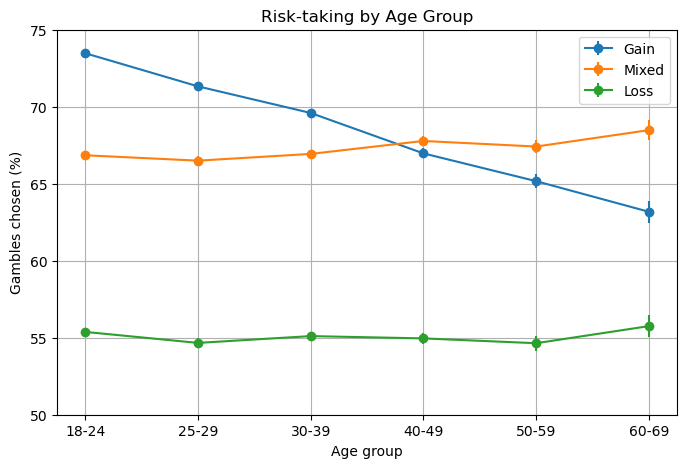

In [44]:
# numpy 배열로 변환
ages = np.array(ages)
gain_rates = np.array(gain_rates)
mixed_rates = np.array(mixed_rates)
loss_rates = np.array(loss_rates)

age_groups = range(1, 7)  # 1~6번 그룹만 (18~69세)

gain_means, gain_sems = [], []
mixed_means, mixed_sems = [], []
loss_means, loss_sems = [], []

for ag in age_groups:
    mask = ages == ag
    gain_vals = gain_rates[mask]
    mixed_vals = mixed_rates[mask]
    loss_vals = loss_rates[mask]

    gain_means.append(np.nanmean(gain_vals))
    gain_sems.append(np.nanstd(gain_vals) / np.sqrt(np.sum(mask)))

    mixed_means.append(np.nanmean(mixed_vals))
    mixed_sems.append(np.nanstd(mixed_vals) / np.sqrt(np.sum(mask)))

    loss_means.append(np.nanmean(loss_vals))
    loss_sems.append(np.nanstd(loss_vals) / np.sqrt(np.sum(mask)))

# 그래프
plt.figure(figsize=(8,5))
plt.errorbar(age_groups, gain_means, yerr=gain_sems, label='Gain', fmt='-o')
plt.errorbar(age_groups, mixed_means, yerr=mixed_sems, label='Mixed', fmt='-o')
plt.errorbar(age_groups, loss_means, yerr=loss_sems, label='Loss', fmt='-o')
plt.xticks(age_groups, ['18-24', '25-29', '30-39', '40-49', '50-59', '60-69'])
plt.xlabel("Age group")
plt.ylabel("Gambles chosen (%)")
plt.title("Risk-taking by Age Group")
plt.ylim(50, 75)
plt.grid(True)
plt.legend()
plt.show()
